# Lab 2: Cats vs Dogs

**Deadline**: May 22, 9pm

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.


## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/open?id=1X0UuZ-4urAXVe9BzazDNQHkqkEytxpos

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [5]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch


0it [00:00, ?it/s]

100%|█████████▉| 170467328/170498071 [00:28<00:00, 7786357.89it/s]

Files already downloaded and verified


170500096it [00:39, 7786357.89it/s]                               

### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

torch.Size([32, 32, 3])
tensor([5])
torch.Size([32, 32, 3])
tensor([5])
torch.Size([32, 32, 3])
tensor([5])
torch.Size([32, 32, 3])
tensor([3])
torch.Size([32, 32, 3])
tensor([3])
torch.Size([32, 32, 3])
tensor([3])
torch.Size([32, 32, 3])
tensor([5])
torch.Size([32, 32, 3])
tensor([5])
torch.Size([32, 32, 3])
tensor([3])
torch.Size([32, 32, 3])
tensor([5])
torch.Size([32, 32, 3])
tensor([5])
torch.Size([32, 32, 3])
tensor([3])
torch.Size([32, 32, 3])
tensor([3])
torch.Size([32, 32, 3])
tensor([5])
torch.Size([32, 32, 3])
tensor([5])


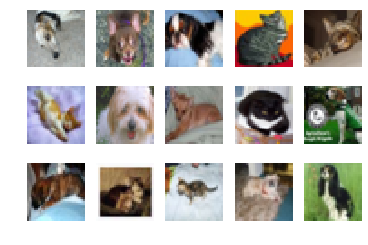

In [7]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    print(img.shape)
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    print(labels)
  
    k += 1
    if k > 14:
        break
        

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [0]:
print("There are " + str(len(train_loader)) + " training examples")
print("There are " + str(len(val_loader)) + " validation examples")
print("There are " + str(len(test_loader)) + " test examples")

There are 8000 training examples
There are 2000 validation examples
There are 2000 test examples


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

1. A validation set provides an unbiased evaluation of a model fit on the training dataset while tuning the model's hyperparameters (eg. number of neurons in each layer, choice of activation functions, number of hidden layers, batch size, learning rate). After training a given model, validation set is used to evaluate the performance of the model for different combinations of hyperparameter values. Based on the validation curves, you can keep the best training model.
Validation set can also be used for regularization of early stopping: stop training when the error on the validation set increases, as this is a sign of overfitting on the training set. 

2. The error on the training set does not provide an accurate evaluation on the performance of the our models since all the parameters are tuned based on the training set. If we judge the performance based on the training set, our models will overfit the training set and the actual performance on the test sets will be sacrificed.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [0]:
for param in small_net.parameters():
    print(param.shape)
    
parameter_small = (5*3*3*3) + 5 + (1*245) + 1
print("There are " + str(parameter_small) + " parameters in the small_net")

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
There are 386 parameters in the small_net


In [0]:
for param in large_net.parameters():
    print(param.shape)
    
parameter_large = (5*3*5*5) + 5 + (10*5*5*5) + 10 + (32*250) + 32 + (1*32) + 1
print("There are " + str(parameter_large) + " parameters in the large_net")

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
There are 9705 parameters in the large_net


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

<img src="Diagram.png" width=60%>

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [0]:
print(train_net.__defaults__)
print("The default batch_size is 64, the default learning_rate is 0.01, the default num_epoches is 30")

(64, 0.01, 30)
The default batch_size is 64, the default learning_rate is 0.01, the default num_epoches is 30


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

 1. "model_small_bs64_lr0.01_epoch4_train_err.csv" contains the training error for each epoch. The training error is obtained by summing all the errors in one epoch and normalize it by the number of the entire data set.
 
 2. "model_small_bs64_lr0.01_epoch4_train_loss.csv" contains the training loss for each epoch. This is caluculated by dividing the total losses for one epoch by the number of batches in the train_loader.  
 
 3. "model_small_bs64_lr0.01_epoch4_val_err.csv" contains the validation error for each epoch. The error is calculated based on the validation set. In each epoch, the parameters in the network are updated and a new error is calculated according to the new model. 
 
 4. "model_small_bs64_lr0.01_epoch4_val_loss.csv" contains the validation loss for each epoch. This is also calculated based on the validation set. We use the same loss function to calculate the validation loss and the loss is calculated in each epoch.

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [0]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cd /content/gdrive
!ls -la /content/gdrive
!pwd

total 8
drwx------ 8 root root 4096 May 25 18:38 'My Drive'
drwx------ 2 root root 4096 May 25 18:38  .Trash
/content


In [0]:
train_net(small_net,num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)
tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1], dtype=torch.uint8)
tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1], dtype=torch.uint8)
tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0],

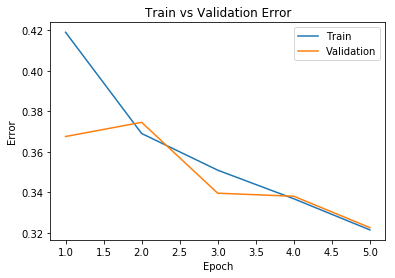

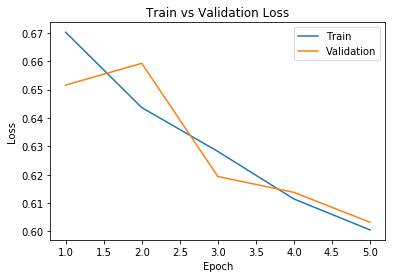

In [0]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=4)
plot_training_curve(model_path)

In [0]:
!pwd

/content


In [0]:
!ls -a /content/gdrive

'My Drive'   .Trash


In [0]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.431875, Train loss: 0.6759696292877198 |Validation err: 0.3715, Validation loss: 0.6542205642908812
Epoch 2: Train err: 0.374125, Train loss: 0.6475685396194458 |Validation err: 0.391, Validation loss: 0.6668402496725321
Epoch 3: Train err: 0.3585, Train loss: 0.6376641368865967 |Validation err: 0.36, Validation loss: 0.6290558315813541
Epoch 4: Train err: 0.352875, Train loss: 0.6278902297019958 |Validation err: 0.358, Validation loss: 0.6257748641073704
Epoch 5: Train err: 0.33975, Train loss: 0.6200957508087158 |Validation err: 0.3405, Validation loss: 0.618204278871417
Epoch 6: Train err: 0.326625, Train loss: 0.607372525215149 |Validation err: 0.334, Validation loss: 0.6067025568336248
Epoch 7: Train err: 0.325625, Train loss: 0.5968901968002319 |Validation err: 0.3195, Validation loss: 0.5987452864646912
Epoch 8: Train err: 0.315375, Train loss: 0.5866383023262024 |Validation err: 0.

In [0]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.46575, Train loss: 0.6916063661575318 |Validation err: 0.424, Validation loss: 0.6868563089519739
Epoch 2: Train err: 0.44125, Train loss: 0.6841172018051147 |Validation err: 0.425, Validation loss: 0.677019476890564
Epoch 3: Train err: 0.407375, Train loss: 0.6712118930816651 |Validation err: 0.3895, Validation loss: 0.6529800817370415
Epoch 4: Train err: 0.371375, Train loss: 0.6495822467803956 |Validation err: 0.3745, Validation loss: 0.6489848457276821
Epoch 5: Train err: 0.35825, Train loss: 0.6349251914024353 |Validation err: 0.359, Validation loss: 0.6379060540348291
Epoch 6: Train err: 0.34675, Train loss: 0.6195054230690002 |Validation err: 0.3405, Validation loss: 0.629112184047699
Epoch 7: Train err: 0.3305, Train loss: 0.6076380581855774 |Validation err: 0.333, Validation loss: 0.6146950908005238
Epoch 8: Train err: 0.3185, Train loss: 0.5886318707466125 |Validation err: 0.334,

Given the same number of iterations, the larger network takes longer to train. Because there are more layers and more parameters in the network thus more computationally expensive. 

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

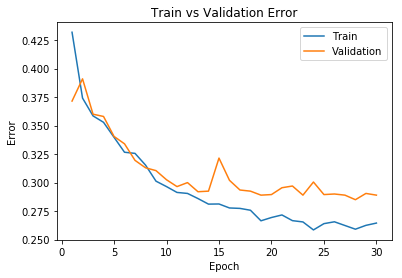

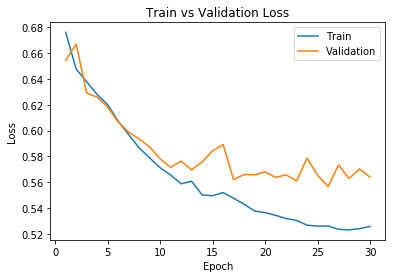

In [0]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

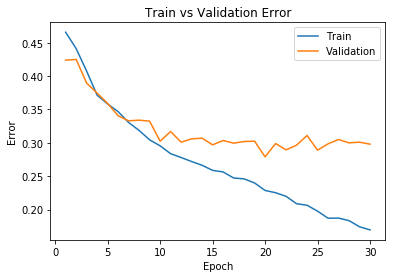

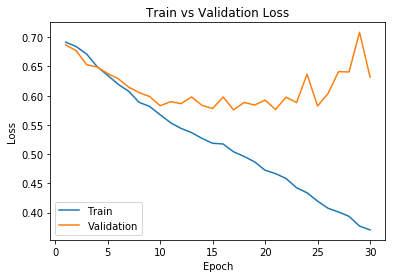

In [0]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

1. Both curves demonstrate a trend of overfitting, because the training errors keep decreasing while the validation errors maintain at the same level or even increase after a certain epoch. The large_net has an obvious occurence of overfitting while the issue is not that obvious for the small net.The overfitting problem of the large net is observed after 15 epoches. The small net has a trend of overfitting at around 30 epoches. 

2. The large net has a smaller validation error. However, the validation loss of the large net is larger as the large net overfits more on the training set.

3. The large net has smaller training error and loss as the large net has more parameters to tune so it should be able to extract more information from the images.

3. There is less noise in the large net because the large net has more convolutional layers and is able to extract more information thus it makes more accurate decisions on updating the parameters.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [0]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

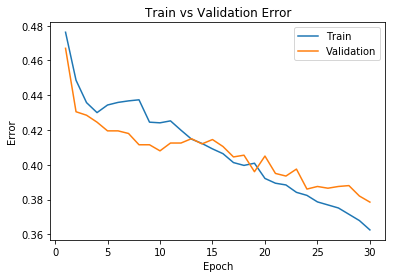

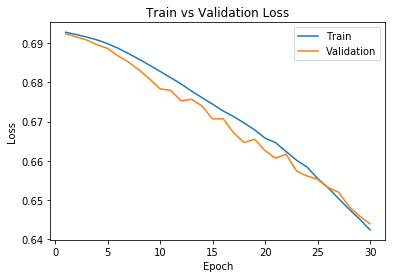

In [0]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

It takes almost the same amount of time to train the networks since the number of epoches(i.e. number of iterations for the entire data sets) and the batch size are the same. The loss and error decreases slower compared to the network with a larger learning rate. This is due to the fact that with a small learning rate, the optimizer takes smaller steps towards the minimum for each iteration. The validation loss and error are less noisy and we do not observe a trend of increase in the validation error, which means it is still underfitting. The performance of the network will be better if we keep training. 

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

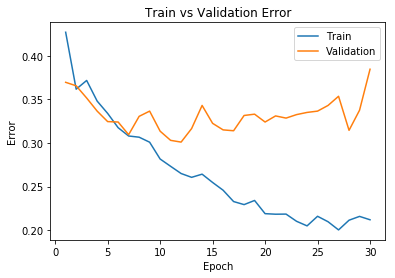

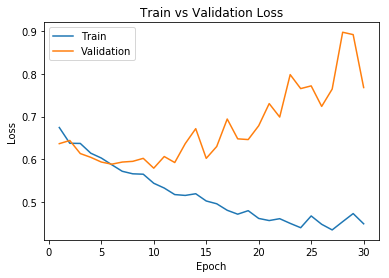

In [0]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

It takes almost the same amount of time to train the networks since the number of epoches(i.e. number of iterations for the entire data sets) and the batch size are the same. The problem of overfitting occurs at around 5 epoches, which means the network takes shorter time to reach its best performance.The validation error and loss are larger due to overfitting. The validation error and loss are more noisy since the model has a larger learning rate (i.e. the model takes a larger step in each update).


### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

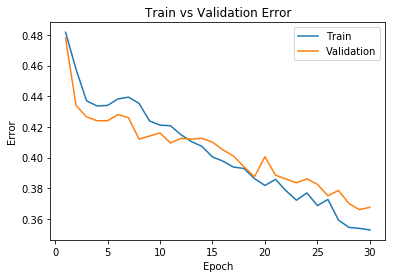

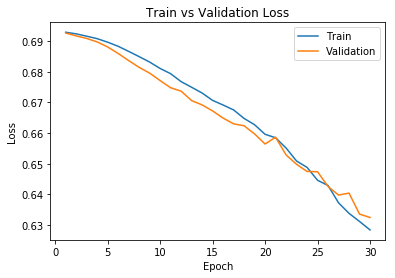

In [0]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

There are fewer iterations for each epoch (1 epoch = total number of data / batch size) and the number of epoches maintains the same so it takes shorter to train the network. In theory, it should take more time for each update since more data is used as references. But based on the above results, the overall training time is shorter. There are less noise in the validation error and loss because the quality of each update is improved. After 30 epoches, the validation curves are still underfitting, so we can get better results if we train the network longer. 

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

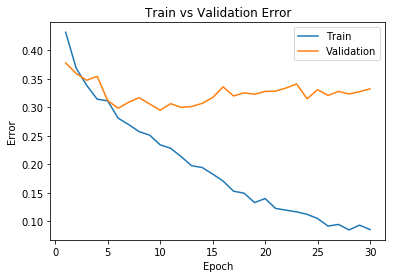

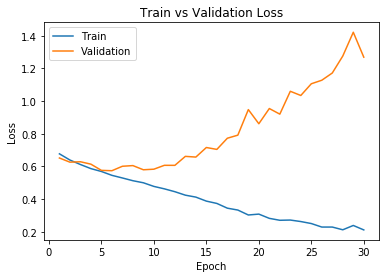

In [0]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

There are more iterations for each epoch (1 epoch = total number of data / batch size) and the number of epoches maintains the same so it takes longer to train the network. In theory, it should take less time to compute the parameters for each update as fewer samples are used as references for each update. However, based on the above results, the overall training time is longer. There are more noise in the validation error and loss because the quality of each update is worse. We should stop training at around 5 epoches since overfitting occurs at around that point. 

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Based on the observation from part3, I decided to choose a large_net with a batch size of 64 and a learning rate of 0.005. Other hyperparameters are set to default as required by the question.

According to the plots in part3 a and b, The network with a learning rate of 0.1 is noisy and overfitting the training set while the network with a learning rate of 0.001 is less nosiy but it underfits the training set. The network with the default learning rate overfits the dataset. To mitigate the problem, I chose a learning rate between 0.01 and 0.001.

Same for the batch size. In part 3 c and d, networks with a batch size of 128 has the issue of underfitting, while the network with a batch size of 16 has the issue of overfitting. A batch size of 64 is likely to remediate the issue.

For the network size, I chose the large_net since all the judgements made so far are based on the large_net. Moreover, it has a smaller training error and loss with 30 epoches so it has the potential to perform better if trained correctly. Theoritically speaking, given enough time to train, a larger network should perform better as there are more parameters to tune.


### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.005, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4525, Train loss: 0.6918497996330262 |Validation err: 0.429, Validation loss: 0.6890992727130651
Epoch 2: Train err: 0.441375, Train loss: 0.6870899991989136 |Validation err: 0.4175, Validation loss: 0.6815978400409222
Epoch 3: Train err: 0.4185, Train loss: 0.67998171377182 |Validation err: 0.414, Validation loss: 0.6720786709338427
Epoch 4: Train err: 0.40775, Train loss: 0.6727586693763733 |Validation err: 0.399, Validation loss: 0.6649945117533207
Epoch 5: Train err: 0.3925, Train loss: 0.6650489087104797 |Validation err: 0.3895, Validation loss: 0.6580537501722574
Epoch 6: Train err: 0.375625, Train loss: 0.65449369764328 |Validation err: 0.376, Validation loss: 0.6485188640654087
Epoch 7: Train err: 0.37225, Train loss: 0.6452175946235656 |Validation err: 0.3735, Validation loss: 0.6415566969662905
Epoch 8: Train err: 0.35725, Train loss: 0.6329517650604248 |Validation err: 0.357, Va

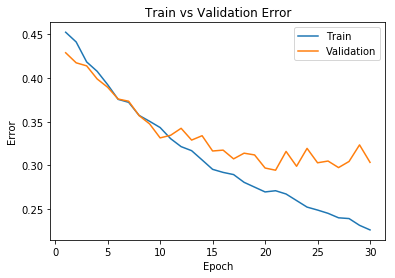

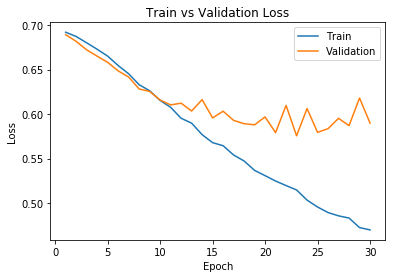

In [0]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

Based on the plots above, I decided to use a large_net with a batch size of 60 and a learning rate of 0.07.

I observed that the model has not reached its overfitting point yet, so I decied to make the model learn faster, bring the error down further and possibly larger noise will be introduced. 

I decied to change the learning rate to 0.07 (slightly larger than above) and the batch size to 60 (slightly smaller than above). I expect to see a more noisy curve but it should get smaller error and loss if overfitting does not occur.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=60, learning_rate=0.007, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44425, Train loss: 0.6909873071891158 |Validation err: 0.4355, Validation loss: 0.6853153547819923
Epoch 2: Train err: 0.430875, Train loss: 0.6824299461805998 |Validation err: 0.418, Validation loss: 0.6764743626117706
Epoch 3: Train err: 0.40775, Train loss: 0.6725147317594556 |Validation err: 0.401, Validation loss: 0.6613744094091303
Epoch 4: Train err: 0.390125, Train loss: 0.6607002789404854 |Validation err: 0.3865, Validation loss: 0.6520659853430355
Epoch 5: Train err: 0.374375, Train loss: 0.648873738388517 |Validation err: 0.3655, Validation loss: 0.6391994497355293
Epoch 6: Train err: 0.353375, Train loss: 0.6331668295967046 |Validation err: 0.361, Validation loss: 0.6337462944142959
Epoch 7: Train err: 0.341125, Train loss: 0.621819706550285 |Validation err: 0.341, Validation loss: 0.6205792129039764
Epoch 8: Train err: 0.330125, Train loss: 0.6065705827812651 |Validation err: 

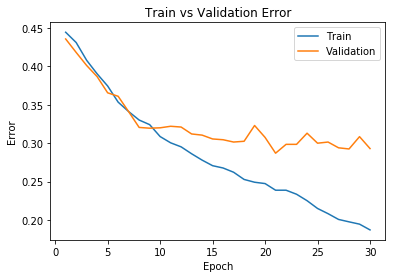

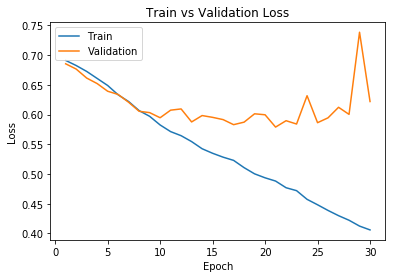

In [0]:
model_path = get_model_name("large", batch_size=60, learning_rate=0.007, epoch=29)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [10 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [0]:
net = LargeNet()
model_path = get_model_name("large", batch_size=60, learning_rate=0.007, epoch=20)
state = torch.load(model_path)
net.load_state_dict(state)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Part (b) - 2pt

Justify your choice of model from part (a).

Based on all the trials in the above sections, the best model I decied to use is a large_net model with a batch size of 60 and a learning rate of 0.006. The model seems to overfit after 21 epoches, so I decied to terminate the training at that point to prevent overfitting. According to the previous sections, the model gives a validation error of 0.287, which is the second smallest among all the errors. Even though this model does not produced the smallest validation error, this model seems to be more stable (i.e. less noisy). So I expect the model to perform well on the test set.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [0]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=60)

test_err, test_loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("the test error is {} " .format(test_err))
print("the test loss is {} " .format(test_loss))

Files already downloaded and verified
Files already downloaded and verified
the test error is 0.298 
the test loss is 0.5654857237549389 


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [0]:
val_err, val_loss = evaluate(net, val_loader, nn.BCEWithLogitsLoss())
print("the validation error is {} " .format(val_err))
print("the validation loss is {} " .format(val_loss))

the validation error is 0.287 
the validation loss is 0.5801318533280316 


The test error is larger than the validation error because the validation set is biased. In the above sections, we tune all the hyperparameters based on the validation error. Even though the model is not trained on the validation set, it has already seen the dataset. Therefore, we can not make our judgements based on its performance on the validation set. The test set provides more accurate evaluation.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

The performance of the nerual network is determined by the test data. If we use the test data eariler in the training state or tuning hyperparameters, the evalutaion will be biased. Therefore, we want to make sure that the test data is not seen by the model such that the test data can provide a fair evaluation.